## Lecture 2 - $25^{th}$ November 2024

This notebook presentation is part of my lecture material for the Advanced Quantum Mechanics course at the University of Trieste. It contains a general introduction to Qiskit and Pennylane

**Michele Grossi**, Coordinator of Hybrid Quantum Computing Infrastracture and Algorithms @ CERN


# Parametrized Quantum Circuit for near terms computation: Real Time evolution
<br>
You can find a copy of this presentation at

https://github.com/grossiM/LAB_Quantum_Computation24/tree/main

michele.grossi@cern.ch

### Libraries check

In [1]:
# Install libraries if needed (uncomment if necessary)

import qiskit
from qiskit import QuantumCircuit
from qiskit.visualization import plot_histogram
import pennylane as qml
from pennylane import numpy as np

/Users/sebastianopian/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
print("Qiskit version:", qiskit.__version__)
print("PennyLane version:", qml.__version__)

Qiskit version: 1.2.4
PennyLane version: 0.38.0


# Parameterized Quantum Circuits (PQC) and Time Evolution of Hamiltonians

In this notebook, we will:
1. Understand Parameterized Quantum Circuits (PQCs) and their role in quantum algorithms.
2. Explore the implementation of PQCs in Qiskit and PennyLane, discussing similarities and differences.
3. Study the time evolution of a Hamiltonian, focusing on Ising-like models, with examples in Qiskit and PennyLane.


## What are PQCs?

A Parameterized Quantum Circuit (PQC) is a quantum circuit with tunable parameters, often used in:
- Variational Quantum Algorithms (e.g., VQE, QAOA, Time Evolution).
- Quantum Machine Learning models.
- Quantum state preparation.

### Key Components:
1. **Parameterized Gates**: Quantum gates with tunable angles, such as RX, RY, RZ.
2. **Optimization Loop**: Classical optimizer adjusts parameters to minimize/maximize an objective function.

PQCs combine the power of quantum mechanics with classical optimization to solve complex problems.


#### PQCs in Qiskit

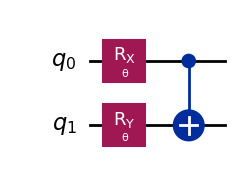

In [3]:
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter

# Define a parameter
theta = Parameter("θ")

# Create a PQC
qc = QuantumCircuit(2)
qc.rx(theta, 0)
qc.ry(theta, 1)
qc.cx(0, 1)
qc.draw('mpl')


#### PQCs in Pennylane

In [4]:
import pennylane as qml
from pennylane import numpy as np

# Define a device
dev = qml.device("default.qubit", wires=2)

# Define a PQC
@qml.qnode(dev)
def pqc(params):
    qml.RX(params[0], wires=0)
    qml.RY(params[1], wires=1)
    qml.CNOT(wires=[0, 1])
    return qml.expval(qml.PauliZ(0))

# Example parameters
params = [np.pi/4, np.pi/4]
print(f"Expectation value: {pqc(params)}")


Expectation value: 0.7071067811865475


| Feature                   | Qiskit                         | PennyLane                     |
|---------------------------|---------------------------------|--------------------------------|
| Backend Flexibility       | IBM Quantum, Aer Simulator     | Customizable device options   |
| Parameter Handling        | `Parameter` objects            | NumPy-like arrays             |
| Execution Style           | Circuit-based execution        | Function-based execution      |
| Differentiability         | Limited                        | Built-in differentiability    |


####  Exercise: Modify and Compare PQCs
**Task**: Modify the PQCs above to include:
1. An additional RX gate on the second qubit.
2. A measurement step in Qiskit.

Discuss how parameter handling differs in Qiskit and PennyLane.


## Time Evolution of a Hamiltonian
As a real time evolution technique, the Trotterization or Trotterized Real Time Evolution (RTE) consists in the successive application of a quantum gate, assumed to approximate the time evolution of a system for a time slice [1]. Following from the Schrödinger equation, the time evolution of a system initially in the state $\vert\psi(0)\rangle$ takes the form:

$$
\vert \psi(t) \rangle = e^{-i H t} \vert \psi(0) \rangle \text{,}
$$

where $H$ is the time-independent Hamiltonian under which the system is submitted. We consider a Hamiltonian that can be written as a weighted sum of Pauli terms $H=\sum_j a_j H_j$, with $h_j$ representing a tensor product of Pauli terms acting on $n$ qubits. Thus, the sequence of gates that approximate a single evolution step is found under the assumption that the product of matrix exponentials is a good approximation for the sum of matrix exponentials:

$$
\vert \psi(t) \rangle \approx \left(\prod_j e^{-i a_j H_j t/r} \right)^r \vert\psi(0) \rangle \text{,}
$$

where $t/r$ is the time slice (evolution step) that we are choosing. As a result, a gate to be applied $r$ times is created. A smaller timestep leads to a more accurate approximation. However, this also leads to deeper circuits which, in practice, leads to more error accumulation, becoming a critical aspect especially on NISQ devices. For the purposes of this tutorial, all simulations are Statevector simulator, which doesn't include any shot or hardware noise.

## Time Evolution of a Hamiltonian (summary)

The time evolution of a quantum state under a Hamiltonian $( H )$ is governed by:
$
|\psi(t)\rangle = e^{-iHt}|\psi(0)\rangle
$

In practice, we often decompose $( e^{-iHt} )$ using:
- **Trotterization**: Approximation by small time steps.
- **Efficient Gate Decomposition**: For specific Hamiltonians like the Ising model.

### Ising Model Hamiltonian
The Ising model is represented as:
$
H = \sum_{i} J_i Z_i Z_{i+1} + \sum_{i} h_i X_i
$


## Classical Simulation of Time Evolution

For small systems, the time evolution of the state can be solved classically by:
1. Diagonalizing the Hamiltonian \( H \) to find its eigenvalues $( E_i )$ and eigenvectors $ |\phi_i\rangle$.
2. Evolving the state $ |\psi(0)\rangle $ as:
   $
   |\psi(t)\rangle = \sum_i c_i e^{-i E_i t} |\phi_i\rangle
   $
   where $ c_i = \langle \phi_i | \psi(0) \rangle $.

This approach provides the exact solution for small systems, which can be compared to quantum simulations.


In [5]:
import numpy as np
from scipy.linalg import expm
from functools import reduce  # Import reduce explicitly

# Define the Ising Hamiltonian as a matrix
def ising_hamiltonian(J, h, n_qubits):
    """
    Build the Ising Hamiltonian for n_qubits.
    H = J Σ Z_i Z_{i+1} + h Σ X_i
    """
    # Pauli matrices
    I = np.eye(2)
    X = np.array([[0, 1], [1, 0]])
    Z = np.array([[1, 0], [0, -1]])
    
    # Initialize Hamiltonian
    H = np.zeros((2**n_qubits, 2**n_qubits), dtype=complex)
    
    # Interaction term: J Σ Z_i Z_{i+1}
    for i in range(n_qubits - 1):
        op = [I] * n_qubits
        op[i] = Z
        op[i + 1] = Z
        H += J * reduce(np.kron, op)  # Use functools.reduce
    
    # External field term: h Σ X_i
    for i in range(n_qubits):
        op = [I] * n_qubits
        op[i] = X
        H += h * reduce(np.kron, op)  # Use functools.reduce
    
    return H

# Parameters
J = 1.0  # Coupling constant
h = 0.5  # External field
n_qubits = 2  # Number of qubits
time_steps = 100  # Number of time steps
t_max = 10.0  # Maximum evolution time

#times = np.linspace(0, 2 * np.pi, 100)  # Evolution times

# Initial state |00⟩
initial_state = np.zeros(2**n_qubits, dtype=complex)
initial_state[0] = 1

# Build the Hamiltonian
H = ising_hamiltonian(J, h, n_qubits)

# Time evolution
times = np.linspace(0, t_max, time_steps)
classical_results = []
for t in times:
    # Evolve the state
    U = expm(-1j * H * t)  # e^(-iHt)
    evolved_state = U @ initial_state
    # Measure Z on the first qubit
    Z_op = np.array([[1, 0], [0, -1]])
    Z1 = np.kron(Z_op, np.eye(2**(n_qubits - 1)))  # Z on qubit 0
    expectation = np.vdot(evolved_state, Z1 @ evolved_state).real
    classical_results.append(expectation)


In [6]:
##Alternative

# Classical solution: Time evolution
def classical_time_evolution(J, h, time):
    # Define the Ising Hamiltonian as a matrix
    H = np.array([
        [J, h, h, -J],
        [h, -J, J, h],
        [h, J, -J, h],
        [-J, h, h, J],
    ], dtype=np.complex128)

    # Initial state |00⟩
    psi_0 = np.array([1, 0, 0, 0], dtype=np.complex128)

    # Time evolution: e^(-iHt) @ psi_0
    U = expm(-1j * H * time)  # Matrix exponential
    psi_t = U @ psi_0
    return psi_t


#### Time Evolution in Pennylane

In [7]:
# PennyLane: Time evolution simulation
from pennylane import numpy as pnp

# PennyLane: Time evolution simulation
def pennylane_time_evolution(J, h, n_qubits, time):
    # Define the Hamiltonian
    coeffs = [J, h]
    obs = [
        qml.PauliZ(0) @ qml.PauliZ(1),
        qml.PauliX(0),
    ]
    hamiltonian = qml.Hamiltonian(coeffs, obs)  # Correct import

    # Device
    dev = qml.device("default.qubit", wires=n_qubits)

    @qml.qnode(dev)
    def circuit():
        # Initial state |00⟩
        qml.BasisState(pnp.array([0, 0]), wires=range(n_qubits))
        # Time evolution
        qml.ApproxTimeEvolution(hamiltonian, time, 1)
        return qml.state()

    return circuit()

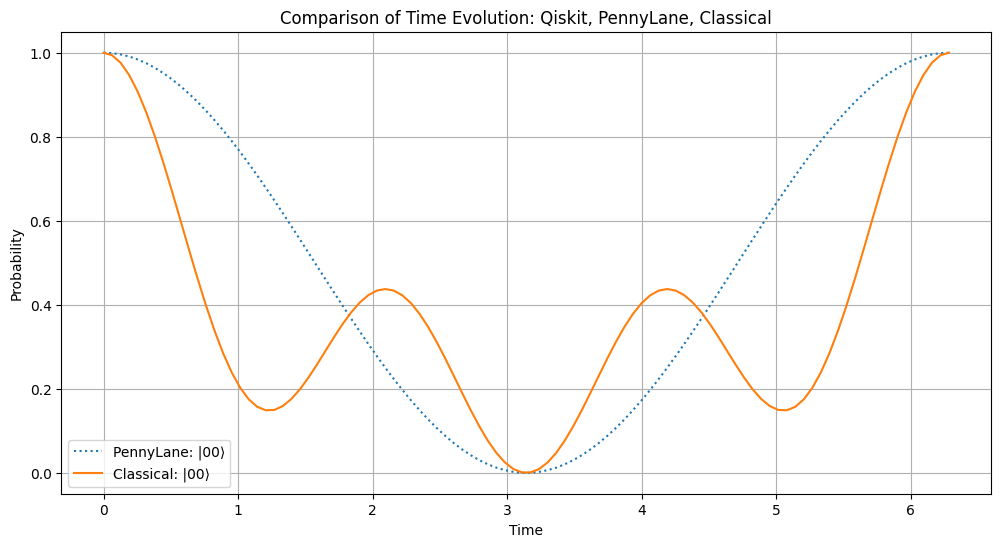

In [8]:
import matplotlib.pyplot as plt

# Parameters
J = 1.0
h = 0.5
n_qubits = 2
times = np.linspace(0, 2 * np.pi, 100)  # Evolution times


# Collect results
pennylane_results = []
classical_results = []


for t in times:

    # PennyLane
    pennylane_state = pennylane_time_evolution(J, h, n_qubits, t)
    pennylane_results.append(pennylane_state)

    # Classical
    classical_state = classical_time_evolution(J, h, t)
    classical_results.append(classical_state)

# Convert to probabilities
pennylane_probs = [np.abs(state) ** 2 for state in pennylane_results]
classical_probs = [np.abs(state) ** 2 for state in classical_results]

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(times, [prob[0] for prob in pennylane_probs], label="PennyLane: |00⟩", linestyle=":")
plt.plot(times, [prob[0] for prob in classical_probs], label="Classical: |00⟩", linestyle="-")
plt.xlabel("Time")
plt.ylabel("Probability")
plt.title("Comparison of Time Evolution: Qiskit, PennyLane, Classical")
plt.legend()
plt.grid()
plt.show()

We recommend using TrotterProduct as the more general operation for approximate matrix exponentiation. 
One can recover the behaviour of ApproxTimeEvolution by taking the adjoint:
`qml.adjoint(qml.TrotterProduct(hamiltonian, time, order=1, n=n))`

see https://docs.pennylane.ai/en/stable/code/api/pennylane.ApproxTimeEvolution.html

#### NEXT EXAMPLE

In this tutorial, we will implement real time evolutions using the `TrotterQRTE` class. To illustrate this, we will study the time evolution of the [Ising model](https://en.wikipedia.org/wiki/Ising_model) on linear lattices of $L=2$ and $L=6$ sites. These lattices consist of an array of spins $\sigma_i$ that interact only with their nearest neighbors. These spins can have two orientations: $\uparrow$ and $\downarrow$, which correspond to a magnetization of $+1$ and $-1$ respectively.

$$
H = - J \sum_{i=0}^{L-2} \sigma_i \sigma_{i+1} - h \sum_{i=0}^{L-1} \sigma_i  \text{,}
$$

where $J$ describes the interaction energy, and $h$ the magnitude of an external field. Let us write this expression using Pauli matrices, and considering that the external field has an angle $\alpha$ with respect to the transversal direction,

$$
H = -J \sum_{i=0}^{L-2} Z_i Z_{i+1} -h \sum_{i=0}^{L-1} (\sin\alpha Z_i + \cos\alpha X_i) \text{.}
$$

In the computational basis, the system will be encoded as follows:

| Quantum state            | Spin representation                        |
|:------------------------:|:------------------------------------------:|
| $\lvert 0 0 0 0 \rangle$ | $\uparrow\uparrow\uparrow\uparrow$         |
| $\lvert 1 0 0 0 \rangle$ | $\downarrow\uparrow\uparrow\uparrow$       |
| $\ldots$                 | $\ldots$                                   |
| $\lvert 1 1 1 1 \rangle$ | $\downarrow\downarrow\downarrow\downarrow$ |

First, we will create a function that takes in the system parameters $L$, $J$, $h$ and $\alpha$, and returns our Hamiltonian as a `SparsePauliOp`. A [SparsePauliOp](https://qiskit.org/documentation/stubs/qiskit.quantum_info.SparsePauliOp.html) is a sparse representation of an operator in terms of weighted [Pauli](https://qiskit.org/documentation/stubs/qiskit.quantum_info.Pauli.html) terms.

In [9]:
from qiskit.quantum_info import SparsePauliOp
from math import sin, cos


def get_hamiltonian(L, J, h, alpha=0):

    # List of Hamiltonian terms as 3-tuples containing
    # (1) the Pauli string,
    # (2) the qubit indices corresponding to the Pauli string,
    # (3) the coefficient.
    ZZ_tuples = [("ZZ", [i, i + 1], -J) for i in range(0, L - 1)]
    Z_tuples = [("Z", [i], -h * sin(alpha)) for i in range(0, L)]
    X_tuples = [("X", [i], -h * cos(alpha)) for i in range(0, L)]

    # We create the Hamiltonian as a SparsePauliOp, via the method
    # `from_sparse_list`, and multiply by the interaction term.
    hamiltonian = SparsePauliOp.from_sparse_list([*ZZ_tuples, *Z_tuples, *X_tuples], num_qubits=L)
    return hamiltonian.simplify()

Let us get started, and create a Hamiltonian as an operator for $L=2$, and a choice of $J=0.2$, $h=1$ and $\alpha=\pi/8$:

In [10]:
from math import pi

H = get_hamiltonian(L=2, J=0.2, h=1.0, alpha=pi / 8)
H

SparsePauliOp(['ZZ', 'IZ', 'ZI', 'IX', 'XI'],
              coeffs=[-0.2       +0.j, -0.38268343+0.j, -0.38268343+0.j, -0.92387953+0.j,
 -0.92387953+0.j])

Let us create an instance of `TimeEvolutionProblem`. Conceptually, it contains all the information relevant on the physical problem. In our case, we will pass it the our Hamiltonian, an initial state, a final time. As initial state, we will take a spin up and a spin down.

In [11]:
from qiskit.quantum_info import Statevector
from qiskit_algorithms import TimeEvolutionProblem

final_time = 1.6

# First spin up, second spin down
# (remember that the labels are interpreted from right to left)
initial_state = Statevector.from_label("10")

problem = TimeEvolutionProblem(H, initial_state=initial_state, time=final_time)

We can now create an instance of `TrotterQRTE`. Conceptually, it contains the information relevant to solve a physical problem, which does by means of the method `evolve`. See https://qiskit.org/ecosystem/algorithms/stubs/qiskit_algorithms.TrotterQRTE.html for additional info and https://github.com/Qiskit/qiskit/blob/main/qiskit/circuit/library/pauli_evolution.py for the qiskit implementation of Trotter (this was done manually in previous editions :-) )

In [12]:
from qiskit_algorithms import TrotterQRTE

trotter = TrotterQRTE()
result = trotter.evolve(problem)

Our evolved state is in the result's attribute `evolved_state`, which is a `QuantumCircuit`,

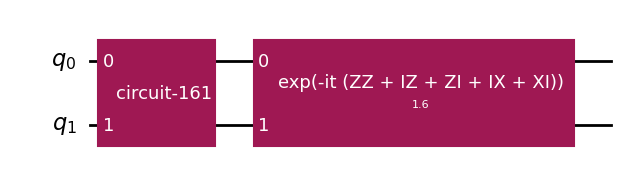

In [13]:
result.evolved_state.draw("mpl")

By sequentially decomposing the circuit, we can show it in terms of Qiskit's [Circuit Library](https://qiskit.org/documentation/apidoc/circuit_library.html) standard gates.

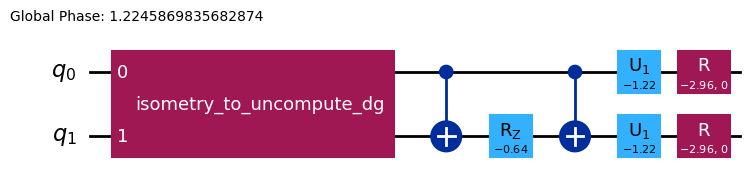

In [14]:
result.evolved_state.decompose(reps=2).decompose("disentangler_dg").decompose(
    "multiplex1_reverse_dg"
).draw("mpl")

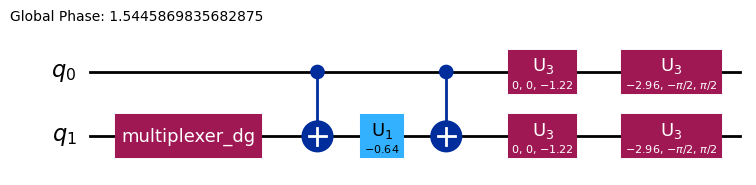

In [15]:
result.evolved_state.decompose(reps=2).decompose().draw("mpl")

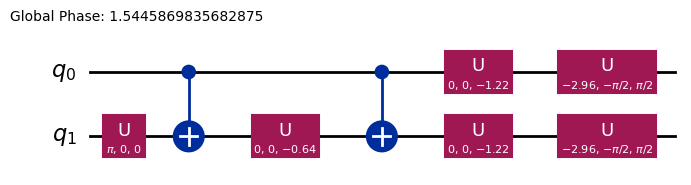

In [16]:
result.evolved_state.decompose(reps=2).decompose().decompose().decompose().draw("mpl")

The evolved state, like all `QuantumCircuit`s, can be turned into a `Statevector`.

In [17]:
statevector = Statevector(result.evolved_state)
print(statevector)

Statevector([ 0.02895926+0.08738739j, -0.9411211 +0.31187756j,
              0.00811432-0.002689j  ,  0.02895926+0.08738739j],
            dims=(2, 2))


Let us find out the effect of the field direction after a certain a certain time $t=1.6$. Note that the units of time are the inverse of the units of the Hamiltonian. For the purposes of this tutorial we leave all units dimensionless.

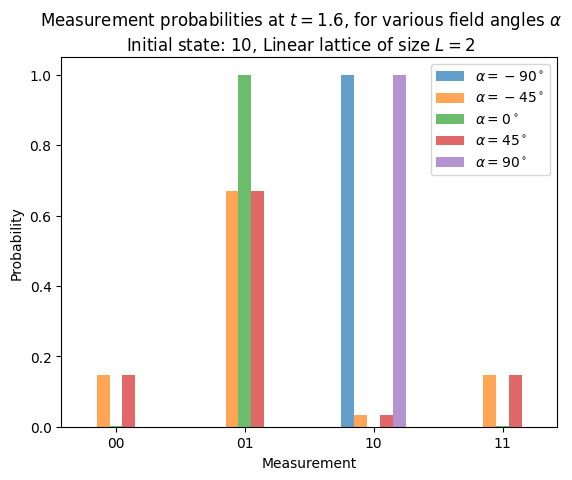

In [18]:
import numpy as np
import matplotlib.pyplot as plt

bar_width = 0.1
# We prepare an initial state ↑↓ (01).
# Note that Statevector and SparsePauliOp interpret the qubits from right to left
initial_state = Statevector.from_label("10")
trotter = TrotterQRTE()
final_time = 1.6
eps = 1e-5

# We create the list of angles in radians, with a small epsilon
# the exactly longitudinal field, which would present no dynamics at all
alphas = np.linspace(-np.pi / 2 + eps, np.pi / 2 - eps, 5)

for i, alpha in enumerate(alphas):
    H_alpha = get_hamiltonian(L=2, J=0.2, h=1.0, alpha=alpha)
    problem = TimeEvolutionProblem(H_alpha, initial_state=initial_state, time=1.6)
    result = trotter.evolve(problem)
    evolved_state = Statevector(result.evolved_state)
    # Dictionary of probabilities
    amplitudes_dict = evolved_state.probabilities_dict()
    labels = list(amplitudes_dict.keys())
    values = list(amplitudes_dict.values())
    # Convert angle to degrees
    alpha_str = f"$\\alpha={int(np.round(alpha * 180 / pi))}^\\circ$"
    plt.bar(np.arange(4) + i * bar_width, values, bar_width, label=alpha_str, alpha=0.7)

plt.xticks(np.arange(4) + 2 * bar_width, labels)
plt.xlabel("Measurement")
plt.ylabel("Probability")
plt.suptitle(
    f"Measurement probabilities at $t={final_time}$, for various field angles $\\alpha$\n"
    f"Initial state: 10, Linear lattice of size $L=2$"
)
plt.legend()

We have prepared a system initially with a sequence of spins $\uparrow\downarrow$, which corresponds to $\vert\psi(0)\rangle = \vert01\rangle$. After letting it evolve for $t=1.6$ under a transversal field ($\alpha=0^\circ$), we are almost guaranteed to measure $\downarrow\uparrow$, i.e. have a spin swap. (Note that the labels are interpreted from right to left). If the field is longitudinal ($\alpha=\pm90^\circ$), we will have no evolution, therefore we will measure the system as it was initially prepared, $\uparrow\downarrow$. With intermediate angles, at $\alpha=\pm45^\circ$, we will be able to measure all combinations will different probabilities, being a spin swap the most likely with a probability of 67%.

### Auxiliary operators
Let us look into another feature of `TrotterQRTE`. We will now explore its ability to perform time evolutions of a system, while keeping track of some observables. The system that we now consider has a size of $L=6$.

In [19]:
from math import pi

L = 6
H = get_hamiltonian(L=L, J=0.2, h=1.2, alpha=pi / 8)

The `TrotterQRTE` instance now will be created with a `num_timesteps` argument, and an `Estimator` primitive. The Qiskit's `Estimator` primitive estimates expectation values of observables, $\langle\psi\vert\hat{O}\vert\psi\rangle$.

In [20]:
from qiskit_algorithms import TrotterQRTE
from qiskit.primitives import Estimator

num_timesteps = 60
trotter = TrotterQRTE(num_timesteps=num_timesteps, estimator=Estimator())

/var/folders/b6/5cpxpg110g9cj088x4tmqb1h0000gn/T/ipykernel_16747/2834281491.py:5: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  trotter = TrotterQRTE(num_timesteps=num_timesteps, estimator=Estimator())


Let us define a *magnetization operator* $\sum_i Z_i$, and a *mean spin correlation operator* $\sum_i Z_i Z_{i+1} / (L - 1)$.

In [21]:
magnetization_op = SparsePauliOp.from_sparse_list(
    [("Z", [i], 1.0) for i in range(0, L)], num_qubits=L
)
correlation_op = SparsePauliOp.from_sparse_list(
    [("ZZ", [i, i + 1], 1.0) for i in range(0, L - 1)], num_qubits=L
) / (L - 1)

Our new initial state will have the two middle spins facing down, and the `TimeEvolutionProblem` will incorporate some observables that will be kept track of:
1. the energy, i.e. the expectation value of the Hamiltonian, $\langle H\rangle$
2. the magnetization, $\langle \sum_i Z_i \rangle$
3. the mean spin correlation, $\langle\sum_i Z_i Z_{i+1}\rangle/(L-1)$

In [22]:
final_time = 30.0
initial_state = Statevector.from_label("001100")
problem = TimeEvolutionProblem(
    H,
    initial_state=initial_state,
    time=final_time,
    aux_operators=[H, magnetization_op, correlation_op],
)

Again, we let our `TrotterQRTE` evolve our newly created problem instance.

In [23]:
result = trotter.evolve(problem)

The new result also features an `observables` attribute. Let's extract the observables stored in it.

In [24]:
import numpy as np

observables = np.array(np.array(result.observables)[:, :, 0])
observables.shape

(61, 3)

Text(0.5, 0.98, 'Observable evolution')

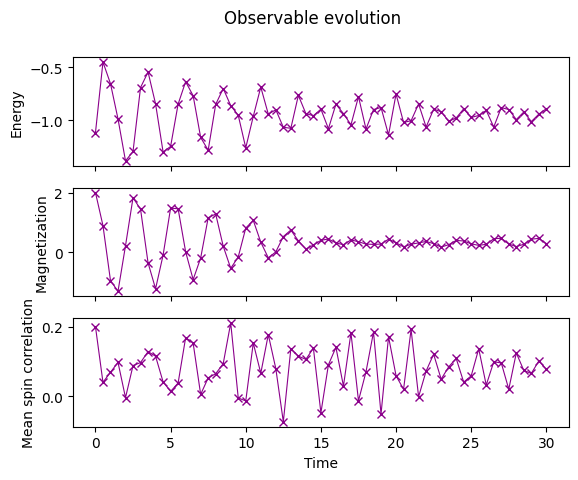

In [25]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(3, sharex=True)
times = np.linspace(0, final_time, num_timesteps + 1)  # includes initial state
axes[0].plot(
    times, observables[:, 0], label="First order", marker="x", c="darkmagenta", ls="-", lw=0.8
)
axes[1].plot(
    times, observables[:, 1], label="First order", marker="x", c="darkmagenta", ls="-", lw=0.8
)
axes[2].plot(
    times, observables[:, 2], label="First order", marker="x", c="darkmagenta", ls="-", lw=0.8
)
axes[0].set_ylabel("Energy")
axes[1].set_ylabel("Magnetization")
axes[2].set_ylabel("Mean spin correlation")
axes[2].set_xlabel("Time")
fig.suptitle("Observable evolution")

### Alternative Classic Solution

Let us verify these results by comparing these expected values using Trotter evolution with the exact ones. To that end, we evaluate directly the expression discussed in the introduction,

$$
\vert \psi(t) \rangle = e^{-i H t} \vert \psi(0) \rangle \text{,}
$$

on each one of the timesteps used by Trotter. We compute this exponential using SciPy's [linalg.expm](https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.expm.html) function, and then we let the initial system evolve using the `Statevector`'s [evolve](https://qiskit.org/documentation/stubs/qiskit.quantum_info.Statevector.evolve.html) method. This becomes too costly to be performed on larger systems very quickly.

In [26]:
import scipy as sc

H_array = H.to_matrix()

# We define a slightly denser time mesh
exact_times = np.linspace(0, final_time, 101)

# We compute the exact evolution using the exp
exact_evolution = [
    initial_state.evolve(sc.linalg.expm(-1j * time * H_array)) for time in exact_times
]

Having the exact state vectors, we compute the exact evolution of our operators' expectation values.

In [27]:
exact_energy = np.real([sv.expectation_value(H) for sv in exact_evolution])
exact_magnetization = np.real([sv.expectation_value(magnetization_op) for sv in exact_evolution])
exact_correlation = np.real([sv.expectation_value(correlation_op) for sv in exact_evolution])

We incorporate the exact evolution of the operators alongside the expected values resulting from the Trotterization.

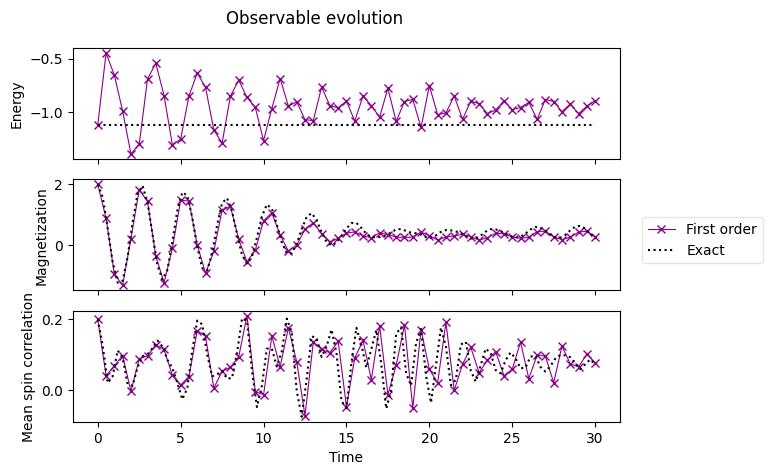

In [28]:
axes[0].plot(exact_times, exact_energy, c="k", ls=":", label="Exact")
axes[1].plot(exact_times, exact_magnetization, c="k", ls=":", label="Exact")
axes[2].plot(exact_times, exact_correlation, c="k", ls=":", label="Exact")
# Select the labels of only the first axis
legend = fig.legend(
    *axes[0].get_legend_handles_labels(),
    bbox_to_anchor=(1.0, 0.5),
    loc="center left",
    framealpha=0.5,
)
fig.tight_layout()
fig

We see that, as an approximation, a Pauli-Trotter evolution isn't too far from the exact solution, but the accuracy is limited. Let's see how to find higher order formulas to address this.

### Product formula overview

If it isn't specified, the default product formula that `TrotterQRTE` uses is the Lie product formula [2], which is at first order. In Qiskit this is implemented in the [LieTrotter](https://qiskit.org/documentation/stubs/qiskit.synthesis.LieTrotter.html) class. A first order formula consists of the approximation stated in the introduction, where the matrix exponential of a sum is approximated by a product of matrix exponentials:

$$
e^{A+B} \approx e^A e^B
$$

There exists a second-order formula, called the Suzuki-Trotter decomposition [3], and can be used in Qiskit by means of the [SuzukiTrotter class](https://qiskit.org/documentation/stubs/qiskit.synthesis.SuzukiTrotter.html). Using this formula, a second order decomposition is:

$$
e^{A+B} \approx e^{B/2}e^{A}e^{B/2}
$$

By means of recursions, higher-order approximations can be found [1].

In [29]:
from qiskit.synthesis import SuzukiTrotter
from qiskit.circuit.library import PauliEvolutionGate

dt = final_time / num_timesteps

fourth_order_formula = SuzukiTrotter(order=4)
trotter_step_fourth_order = PauliEvolutionGate(H, dt, synthesis=fourth_order_formula)
circuit = QuantumCircuit(H.num_qubits)
circuit.append(trotter_step_fourth_order, range(H.num_qubits))
circuit = circuit.decompose(reps=2)

# Let us print some stats
print(
    f"""
Trotter step with Suzuki Trotter (4th order)
--------------------------------------------

                  Depth: {circuit.depth()}
             Gate count: {len(circuit)}
    Nonlocal gate count: {circuit.num_nonlocal_gates()}
         Gate breakdown: {", ".join([f"{k.upper()}: {v}" for k, v in circuit.count_ops().items()])}

"""
)


Trotter step with Suzuki Trotter (4th order)
--------------------------------------------

                  Depth: 170
             Gate count: 265
    Nonlocal gate count: 100
         Gate breakdown: CX: 100, U1: 60, R: 55, RZ: 50




Finally, let us perform a simulation at fourth order.

In [30]:
from qiskit.synthesis import SuzukiTrotter

trotter = TrotterQRTE(SuzukiTrotter(order=4), num_timesteps=num_timesteps, estimator=Estimator())
problem = TimeEvolutionProblem(
    H,
    initial_state=initial_state,
    time=final_time,
    aux_operators=[H, magnetization_op, correlation_op],
)
result = trotter.evolve(problem)
observables_order4 = np.array(np.array(result.observables)[:, :, 0], dtype=np.float64)

/var/folders/b6/5cpxpg110g9cj088x4tmqb1h0000gn/T/ipykernel_16747/940414233.py:3: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  trotter = TrotterQRTE(SuzukiTrotter(order=4), num_timesteps=num_timesteps, estimator=Estimator())


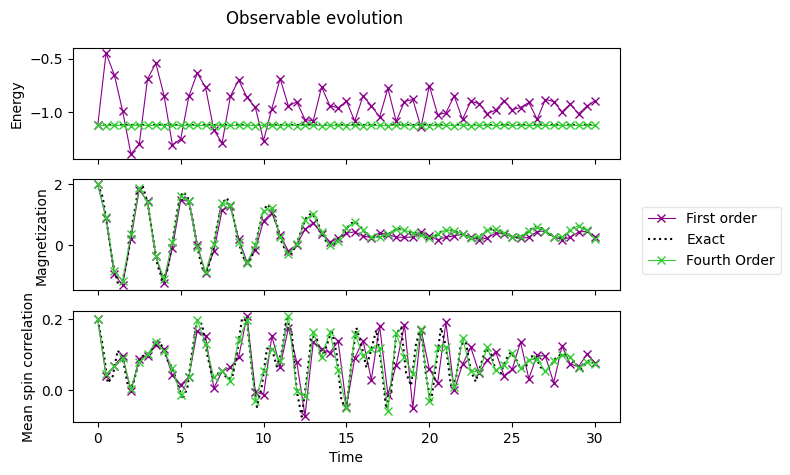

In [31]:
##PLOT THE RESULT
axes[0].plot(
    times, observables_order4[:, 0], label="Fourth Order", marker="x", c="limegreen", ls="-", lw=0.8
)
axes[1].plot(
    times, observables_order4[:, 1], label="Fourth Order", marker="x", c="limegreen", ls="-", lw=0.8
)
axes[2].plot(
    times, observables_order4[:, 2], label="Fourth Order", marker="x", c="limegreen", ls="-", lw=0.8
)

# Replace the legend
legend.remove()
legend = fig.legend(
    *axes[0].get_legend_handles_labels(),
    bbox_to_anchor=(1.0, 0.5),
    loc="center left",
    framealpha=0.5,
)
fig

As it is to expect, we can directly see that a higher-order product formula leads to more accurate expectation values.

### Notes on computing magnetization 
By adding at the end of the circuit a measurement in the computational basis, we get an estimate of the probabilities $p_0^{(i)},p_1^{(i)}$ of finding each qubit in one of the two eigenstates of $\sigma_z$ (i.e. $\left|0\right\rangle$ and $\left|1\right\rangle$) and therefore with an estimate of the average spin magnetization along the $z$ direction
$$
\left\langle\hat{s}^{(i)}_z(t)\right\rangle = \frac{1}{2}\left\langle\psi (t)\right|\sigma^{(i)}_z(t)\left|\psi(t)\right\rangle = \frac{1}{2}\left(+1 \cdot p_0^{(i)} -1\cdot p_1^{(i)}\right)
$$
where $\left|\psi(t)\right\rangle = U(t)\left|\psi (0)\right\rangle$ is the time evolved state of the two qubits. In order to obtain a non-trivial time evolution for $\left\langle\hat{s}^{(i)}_z(t)\right\rangle$, we will start from the initial state
$$
\left|\psi (0) \right\rangle = \left|1\right\rangle \otimes \left|0\right\rangle
$$  


### Notes on Trotterization

#### Simulating quantum physics

<p style='text-align: justify;'> Many physical problems of interest can be modeled in terms of differential equations, with a general linear structure like 
$$
\frac{d\vec{x}}{dt} = M\vec{x}
$$
where $M$ is a matrix and $\vec{x}$ a vector. Once an intial condition $\vec{x}(0)$ is given, the formal solution to the above equation is
$$
\vec{x}(t) = e^{Mt}\vec{x}(0)
$$
In quantum mechanics, the paradigmatic example is the Schrödinger equation (here and in the following, we take $\hbar = 1$)
$$
\frac{d\left|\psi\right\rangle}{dt} = -i\mathcal{H}\left|\psi\right\rangle
$$
where $\mathcal{H}$ is known as the Hamiltonian operator. This complex-valued differential equation is solved by computing the unitary time-evolution operator $\mathrm{U}(t) = e^{-i\mathcal{H}t}$. Indeed, once the latter is known, any initial condition can be evolved linearly as
$$
\left|\psi (t)\right\rangle = \mathrm{U}(t)\left|\psi(0)\right\rangle
$$
Simulating a quantum system relies on the ability to program another device, that we keep under our control, to effectively perform, under a suitable encoding, the operation described by the equation above. Such a task, which in most cases essentially reduces to matrix exponentiation, turns out to be provably diffcult on classical computers, mainly due to the exponential increase of the required time and memory resources with the size of the target quantum system, i.e. the object of our simulation.
</p>

<p style='text-align: justify;'> In 1982, Richard Feynman conjectured that using a controllable quantum mechanical system as a computing resource (instead of a classical object, as your PC is) would provide significant advantages in the simulation of quantum systems (see R. Feynman, Int. J. Theor. Phys. __21__, 467). Indeed, just about fifteen years later, in 1996, Seth Lloyd proved that idea to be essentially correct (see S. Lloyd, Science __273__, 1073), with the sole limitation that the system to be simulated only carries local interactions between its constituent subsystems. In these notes, we will thus concentrate on system Hamiltonians of the form
$$
\mathcal{H} = \sum_l \mathcal{H}_l
$$
where $\mathcal{H}_l$ acts locally only on a portion of the total system.

</p>

### Universal quantum computer as a quantum simulator

<p style='text-align: justify;'> Given a certain Hamiltonian $\mathcal{H}$, the problem of computing the corresponding time evolution operator $\mathrm{U}(t) = \exp\left(-i\mathcal{H}t\right)$ is equivalent to the task of implementing a well defined unitary matrix. As it is well known, any quantum computer endowed with a universal set of quantum gates is in principle able to perform any arbitrary unitary transformation, albeit not necessarily in an efficient number of elementary operations. What Lloyd actually proved back in 1996 is precisely that there exist ways for universal quantum computers to compute $\mathrm{U}(t)$ efficiently (i.e. with polynomial time and memory resources in the size of the target system) when $\mathcal{H}$ is a sum of local terms. We will not give here a formal proof of Lloyd's theorem (if you are interested, you can have a look at the original _Science_ paper mentioned in the references), but we will provide some qualitative arguments as a guide for intuition. </p>

<p style='text-align: justify;'> The general idea is based on two fundamental facts: first, in the circuital model for universal quantum computation we can implement general unitary transformations by successively performing elementary unitary operations (_quantum gates_), and appending one unitary $\mathrm{U}_A$ after another $\mathrm{U}_B$ in the circuit results in a total unitary which mathematically is the product $\mathrm{U}_A\mathrm{U}_B$ being applied to the state of the qubit register. Second, any unitary operation $\mathrm{U}$ acting on $N$ qubits can be implemented with $O(2^{2N})$ elementary operations (remember that the dimension of the Hilbert space of $N$ qubits is $d=2^N$). Suppose now that we are given a Hamiltonian which is a sum of local terms
$$
\mathcal{H} = \sum_l^L \mathcal{H}_l
$$
with, say, $L = p\cdot N/2$, where $p$ measures a degree of _locality_ (it can be, for example, the number of nearest neighbors in a lattice, which is the reason why we added a factor 2 in the definition) and $N$ is the total number of qubits required to encode the computation. In general, according to the rules above, computing directly the unitary operator $\mathrm{U}(t) = \exp\left(-i\mathcal{H}t\right)$ requires $O(2^{2N})$ operations, and is therefore exponentially inefficient. However, let us call $m_l$ the dimension of the subsystem over which the action of $\mathcal{H}_l$ is restricted. Typically, we will have $m_l \ll 2^N$, since local terms only involve few-body interactions. In this case, the unitary $\mathrm{U}_l(t) = \exp\left(-i\mathcal{H}_lt\right)$ can be computed with $O(m_l^{2})$ operations. The overall product
$$
\prod_l \mathrm{U}_l(t)
$$
can therefore be obtained on a universal quantum computer by juxtaposing the circuit implementations of the single $\mathrm{U}_l(t)$ unitaries and takes at most $O(Lm_{max}^2)$ elementary operations, where $m_{max} = \max_l m_l$. The final step of the reasoning lies in the following mathematical identity, which is known as the Suzuki-Trotter (ST) decomposition:
$$
e^{-i\sum_l \mathcal{H}_l t} = \lim_{n\to\infty} \left(\prod_l e^{-i \mathcal{H}_l t/n}\right)^n
$$
Unless all the $\mathcal{H}_l$ operators commute in the mathematical sense, in which case the ST identity is exact already for $n=1$, the product of local unitaries will not be exactly equal to the total target unitary $\mathrm{U}(t) = \exp\left(-i\mathcal{H}t\right)$. However, it can be shown that $\forall n$
$$
\mathrm{U}(t) = e^{-i\sum_l \mathcal{H}_l t} = \left(\prod_l e^{-i \mathcal{H}_l t/n}\right)^n + O\left(\frac{t^2}{n}\right)
$$
which means that we can approximate arbitrarily well the desired unitary operator by repeating $n$ times the sequence of gates corresponding to the product of local terms for time slices $t/n$. All in all, we were able to break our original problem into smaller pieces $e^{-i \mathcal{H}_l t/n}$ which can now be implemented efficiently using only a limited set of elementary gates and which give the correct answer up to an arbitrarily small _digitalization_ error. Indeed, for any $\epsilon > 0$ and $t$, there exist a $n_\epsilon$ such that $\mathrm{U}(t)$ can be computed within an approximation $\epsilon$ in at most $n_\epsilon Lm_{max}^2$ operations. This is polynomial in $N$ whenever $L = \text{poly}(N)$, as it is for example the case for nearest neighbors interactions.
</p>

### The Suzuki-Trotter formula

<p style='text-align: justify;'> Before proceeding with more specific quantum simulations techniques and examples, let us spend a few more comments on the ST formula which constitutes the fundamental basis of all such applications. An intuitive interpretation of its working principles can be given with two examples. The first one is rather qualitative and was suggested by Lloyd himself in his original paper on quantum simulations. Imagine you want to parallel park your car between two other cars in a space that is just an $\epsilon$ longer than what you need: the best strategy would be to place you car just next to the empty spot, parallel to the sidewalk, and then shift laterally. Unfortunately, no car can normally do such a thing, since it is bound to move only back and forth in arcs with a limited curvature, as much as the quantum computer is bound to perform products of local terms if you want your computation to be efficient. However, as everyone is told in drivng schools, you can always parallel park your car (actually, in a space which is just $\epsilon$ longer than the car itself!) by approximating the required trajectory with many _small_ arc movements. _Mutatis mutandis_, this is exactly what the ST formula is doing for the simulation of our target unitary transformation.  </p>

<p style='text-align: justify;'> More quantitatively, we can show the ST formula at work in a simple case which involves 3d rotations. Indeed, it is not difficult to show that (test it yourself with any object on your desk) finite-angle rotations in space around different coordinate axes do not commute in general. Recalling that the quantum state of a qubit can be mapped into a 3-dimensional unit vector on the Bloch sphere (see [Part 1](./Part1.ipynb)), we can explore the behavior of rotations by applying elementary quantum gates. Imagine for example that we start from the north pole of the Bloch sphere (i.e. the basis state $\left|0\right\rangle$) and we want to perform a rotation around the $x=z$ axis by an angle $\theta$. The corresponding unitary operator is (for single qubit rotations, see Exercise 1.3 in [Part 1](./Part1.ipynb)):
$$
\mathrm{R}_{x=z}(\theta) = \exp\left(-i\frac{\theta}{2}\frac{\sigma_x + \sigma_z}{\sqrt{2}}\right)
$$
The average value of an observable, say $\sigma_x$, on the quantum state $\left|\psi(\theta)\right\rangle=\mathrm{R}_{x=z}(\theta)\left|0\right\rangle$ can be computed for any $\theta$ as
$$
\langle\sigma_x\rangle_\theta = \left\langle\psi(\theta)\right|\sigma_x\left|\psi(\theta)\right\rangle
$$
A plot for this quantity is generated by the code below:
</p>

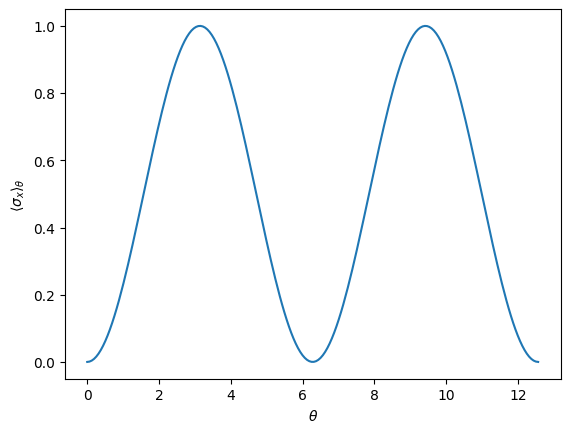

In [32]:
import math 
import matplotlib.pyplot as plt
# Single qubit operators

sx = np.array([[0.0, 1.0],[1.0, 0.0]])
sy = np.array([[0.0, -1.0*1j],[1.0*1j, 0.0]])
sz = np.array([[1.0, 0.0],[0.0, -1.0]])
idt = np.array([[1.0, 0.0],[0.0, 1.0]])

psi0 = np.array([1.0, 0.0])
thetas = np.linspace(0,4*math.pi,200)
avg_sx_tot = np.zeros(len(thetas))

for i in range(len(thetas)):
    psi_theta = expm(-1j*0.5*thetas[i]*(sx+sz)/math.sqrt(2)).dot(psi0)
    avg_sx_tot[i] = np.real(psi_theta.conjugate().transpose().dot(sx.dot(psi_theta)))

plt.plot(thetas,avg_sx_tot)
plt.xlabel(r'$\theta$')
plt.ylabel(r'$\langle\sigma_x\rangle_\theta$')
plt.show()

<p style='text-align: justify;'> However, if we follow the ST spirit and we slice the rotations aroud $x$ and $z$ into smaller pieces, repeating such small moves alternatively we can approximate arbitrarily well the desired rotation
$$
\mathrm{R}_{x=z}(\theta) \simeq \left(\exp\left(-i\frac{\theta}{2n}\frac{\sigma_x}{\sqrt{2}}\right)\exp\left(-i\frac{\theta}{2n}\frac{\sigma_z}{\sqrt{2}}\right)\right)^n \simeq \left(\exp\left(-i\frac{\theta}{2n}\frac{\sigma_z}{\sqrt{2}}\right)\exp\left(-i\frac{\theta}{2n}\frac{\sigma_x}{\sqrt{2}}\right)\right)^n
$$
</p>

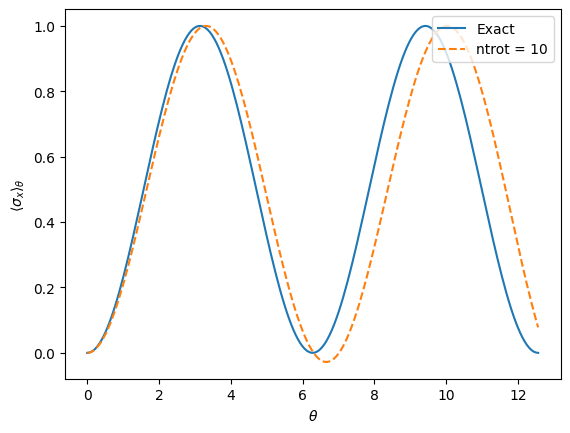

In [33]:
# Try this with e.g. ntrot = 1, 5, 10, 50. 
# You can also try to do sx and sz slices in the reverse order: both choices will become good approximations for large n

ntrot = 10

avg_sx_n = np.zeros(len(thetas))
for i in range(len(thetas)):
    rot = expm(-1j*0.5*thetas[i]*(sx)/(ntrot*math.sqrt(2))).dot(expm(-1j*0.5*thetas[i]*(sz)/(ntrot*math.sqrt(2))))
    for j in range(ntrot-1):
        rot = expm(-1j*0.5*thetas[i]*(sx)/(ntrot*math.sqrt(2))).dot(expm(-1j*0.5*thetas[i]*(sz)/(ntrot*math.sqrt(2)))).dot(rot)
    psi_theta_n = rot.dot(psi0)
    avg_sx_n[i] = np.real(psi_theta_n.conjugate().transpose().dot(sx.dot(psi_theta_n)))
    
plt.plot(thetas,avg_sx_tot)
plt.plot(thetas,avg_sx_n,'--')
plt.xlabel(r'$\theta$')
plt.ylabel(r'$\langle\sigma_x\rangle_\theta$')
plt.legend(['Exact', 'ntrot = ' + str(ntrot)],loc=1)
plt.show()

### Heisenberg model for $N=2$

<p style='text-align: justify;'> Consider the digital quantum simulation of the Heisenberg model of a spin $s=1/2$ dimer with zero external field, which can be easily mapped on a quantum register containing $N = 2$ qubits. The target Hamiltonian is
$$
\mathcal{H} = J'\left( \hat{s}_{x}^{(1)}\hat{s}_{x}^{(2)} + \hat{s}_{y}^{(1)}\hat{s}_{y}^{(2)} + \hat{s}_{z}^{(1)}\hat{s}_{z}^{(2)}\right)
$$
Via the identity $\hat{s}_{\alpha}^{(i)}\rightarrow \sigma_{\alpha}^{(i)}/2$, $\mathcal{H}$ is mapped on the qubits as
$$
\mathrm{H} = J\left( \sigma_x^{(1)}\sigma_x^{(2)} + \sigma_y^{(1)}\sigma_y^{(2)} + \sigma_z^{(1)}\sigma_z^{(2)}\right)
$$
It is straightforward to show (Exercise below) that $[\sigma_\alpha^{(1)}\sigma_\alpha^{(2)},\sigma_\beta^{(1)}\sigma_\beta^{(2)}] = 0 \,\forall \alpha,\beta = x,y,z$ and so the ST formula can be applied exactly with no digital error already with $n = 1$.
</p>

* <p style='text-align: justify;'> __Exercise__ Prove with explicit matrix calculations that $[\sigma_\alpha^{(1)}\sigma_\alpha^{(2)},\sigma_\beta^{(1)}\sigma_\beta^{(2)}] = 0 \,\forall \alpha,\beta = x,y,z$. </p>

<p style='text-align: justify;'> As a result, the total time evolution that we need to simulate can be decomposed into three separate terms:
$$
e^{-i\mathrm{H}t} = e^{-i\delta \sigma_x^{(1)}\sigma_x^{(2)}}e^{-i\delta \sigma_y^{(1)}\sigma_y^{(2)}}e^{-i\delta \sigma_z^{(1)}\sigma_z^{(2)}}
$$
where $\delta = Jt$ is now a dimensionless phase variable. Each one of the factors on the right-hand side of the equation above can be individually seen as a two-qubit unitary operation which can be implemented on the quantum register as a sequence of elementary gates. The simplest transformation to implement is perhaps the so called $\mathrm{ZZ}(\delta)$:
$$
\mathrm{ZZ}(\delta) = e^{-i\delta \sigma_z^{(1)}\sigma_z^{(2)}}
$$
Up to a global phase factor, which can be disregarded when working with quantum states, it corresponds to a combination of two $\mathrm{CNOT}$ gates and a single phase gate (which is called $\mathrm{U}_1(\lambda)$ in qiskit)
$$
\mathrm{ZZ}(\delta) \rightarrow \mathrm{CNOT}(q_c,q_t) \left(\mathcal{I}_{q_c}\otimes\mathrm{U}_{1}(-2\delta)_{q_t}\right) \mathrm{CNOT}(q_c,q_t)
$$
</p>